# Загрузка и первичный осмотр данных

In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')

In [171]:
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [172]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

# Функции для обработки данных

In [173]:
# заполнение пустых ячеек столбцов
def replace_empty_values(column: pd.Series):
    column.replace("", np.nan, inplace=True)

In [174]:
# важные статистические данные: 1-ый и 3-ий квартили, границы выбросов
def main_stat(column: pd.Series):
    perc25 = column.quantile(0.25)
    perc75 = column.quantile(0.75)
    IQR = perc75 - perc25
    print(f' 1-ый квартиль: {perc25}, 3-ий квартиль: {perc75}, IQR: {IQR}. Границы выбросов: [{perc25 - 1.5*IQR}, {perc75 + 1.5*IQR}]')

# Предобработка данных

In [175]:
# гипотеза: столбцы "studytime" и "studytime, granular" полностью скоррелированы 
print(students.studytime.corr(students['studytime, granular']))

-0.9999999999999991


In [176]:
# удалим лишний столбец
students.drop(['studytime, granular'], inplace=True, axis=1)


In [177]:
# удалим пустые ячейки в столбце score: вряд ли понадобятся для обучения модели
students.dropna(axis=0, how="any", subset=["score"], inplace=True)

In [178]:
# заполним пустые ячейки столбцов
for column in students.columns:
    replace_empty_values(column=students[column])

In [179]:
# переименуем столбцы датасета для удобства
new_columns_names = {
    'famsize'    : 'family_size',
    'Pstatus'    : 'parents_marriage_status',
    'Medu'       : 'mother_education',
    'Fedu'       : 'father_education',
    'Mjob'       : 'mother_job',
    'Fjob'       : 'father_job',
    'reason'     : 'school_choice_reason',
    'traveltime' : 'travel_time',
    'studytime'  : 'study_time',
    'schoolsup'  : 'school_educational_support',
    'famsup'     : 'family_educational_support',
    'paid'       : 'maths_tutor',
    'activities' : 'extra_activities',
    'higher'     : 'want_higher_education',
    'famrel'     : 'family_relations',
    
}

students.rename(columns=new_columns_names, inplace=True)

# Анализ данных

## school - аббревиатура школы, в которой учится ученик

In [180]:
display(pd.DataFrame(students.school.value_counts(dropna=False, normalize=True)))

,school
GP,0.884319
MS,0.115681


Как видим, в данном столбце пропусков нет.

## sex - пол ученика ('F' - женский, 'M' - мужской)

In [181]:
display(pd.DataFrame(students.sex.value_counts(dropna=False, normalize=True)))

,sex
F,0.524422
M,0.475578


Снова нет пропусков, идем дальше.

## age - возраст ученика (от 15 до 22)

In [182]:
display(pd.DataFrame(students.age.value_counts(dropna=False, normalize=True)))

,age
16,0.264781
17,0.251928
15,0.210797
18,0.205656
19,0.053985
20,0.007712
22,0.002571
21,0.002571


Пропусков снова нет. Проверим на наличие выбросов:

 1-ый квартиль: 16.0, 3-ий квартиль: 18.0, IQR: 2.0. Границы выбросов: [13.0, 21.0]


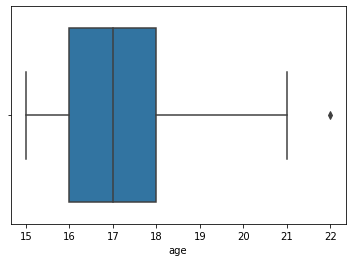

In [183]:
sns.boxplot('age',  data = students)
main_stat(students.age)

Хотя формально выбросом является только значение 22, здравый смысл говорит, что возраст школьников > 18 уже вызывает подозрение. Если возраст 19 лет еще допустим (ребенок мог пойти в школу в 8 лет или остаться на 2-ой год), то возраст 20 лет и более выглядит совсем неправдоподобным. Судя по тому, что таких учеников очень мало, вряд ли речь идет о стране,  где обучение длится более 11 лет. Возможно, это дети, имеющие заболевания, препятствующие нормальному умственному развитию, или особо "трудные" подростки, которым в принципе нужен индивидуальный подход к обучению. Не будем учитывать их в общей статистике:

In [184]:
students = students.loc[students.age <= 19]

## address - тип адреса ученика ('U' - городской, 'R' - за городом)

In [185]:
display(pd.DataFrame(students.address.value_counts(dropna=False, normalize=True)))

,address
U,0.750000
R,0.213542
NaN,0.036458


Около 4% данных в столбце пропущены. Гипотеза: можно предположить, что школьники, живущие за городом, добираются на учебу долго(> 30 мин), и за счет этого заполнить пропуски.

In [186]:
print(students.address[students.travel_time >= 3].value_counts(dropna=False))

R    16
U    12
Name: address, dtype: int64


In [187]:
print(students.address[students.travel_time <= 2].value_counts(dropna=False))

U      258
R       59
NaN     11
Name: address, dtype: int64


Как видим, гипотеза не подтвердилась: есть школьники, которые живут за городом, а добираются до школы быстро, причем таких большинство по отношению к общему количеству живущих за городом. При этом среди живущих в городе тоже есть те, кто добирапется долго. Возможно, школа расположена где-то на окраине

## family_size — размер семьи('LE3' <= 3, 'GT3' >3)

In [188]:
display(pd.DataFrame(students.family_size.value_counts(dropna=False, normalize=True)))

,family_size
GT3,0.653646
LE3,0.276042
NaN,0.070312


Около 7% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

##  parents_marriage_status — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [189]:
display(pd.DataFrame(students.parents_marriage_status.value_counts(dropna=False, normalize=True)))

,parents_marriage_status
T,0.794271
NaN,0.117188
A,0.088542


Около 12% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно).

## mother_education — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [190]:
display(pd.DataFrame(students.mother_education.value_counts(dropna=False, normalize=True)))

,mother_education
4.0,0.338542
2.0,0.257812
3.0,0.244792
1.0,0.143229
0.0,0.007812
NaN,0.007812


Менее 1% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Проверим на наличие выбросов:

 1-ый квартиль: 2.0, 3-ий квартиль: 4.0, IQR: 2.0. Границы выбросов: [-1.0, 7.0]


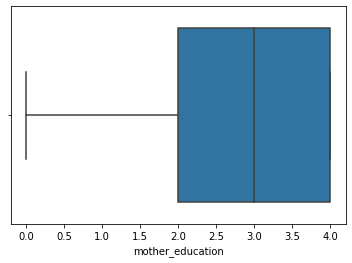

In [191]:
sns.boxplot('mother_education',  data = students)
main_stat(students.mother_education)

Выбросов здесь не наблюдается.

## father_education — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [192]:
display(pd.DataFrame(students.father_education.value_counts(dropna=False, normalize=True)))

,father_education
2.0,0.265625
3.0,0.244792
4.0,0.229167
1.0,0.190104
NaN,0.062500
0.0,0.005208
40.0,0.002604


Около 6% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно). Но заметим, что имеющееся значение 40 - это, скорее всего, опечатка, и имелось в виду 4. Исправим ее:

In [193]:
students.father_education = students.father_education.apply(lambda x: float(str(x).replace('40', '4')))

Проверим на выбросы:

 1-ый квартиль: 2.0, 3-ий квартиль: 4.0, IQR: 2.0. Границы выбросов: [-1.0, 7.0]


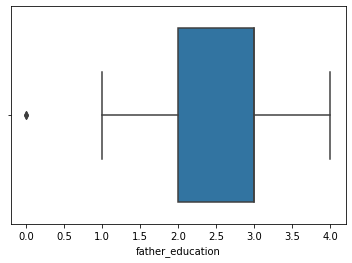

In [194]:
sns.boxplot('father_education',  data = students)
main_stat(students.mother_education)

Несмотря на наличие выброса, здравый смысл говорит нам, что у отсутствие образования у одного из родителей - вполне реальная ситуация (к сожалению, в мире есть много неблагополучных семей). Поэтому выброс не удаляем.

##  mother_job — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [195]:
display(pd.DataFrame(students.mother_job.value_counts(dropna=False, normalize=True)))

,mother_job
other,0.328125
services,0.247396
at_home,0.151042
teacher,0.143229
health,0.080729
NaN,0.049479


Около 5% данных в столбце пропущены. Пока оставим, как есть (оптимальное значение для пропусков неочевидно)

## father_job — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [196]:
display(pd.DataFrame(students.father_job.value_counts(dropna=False, normalize=True)))

,father_job
other,0.497396
services,0.252604
NaN,0.093750
teacher,0.075521
at_home,0.041667
health,0.039062
